In [136]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import healpy as hp
import pandas as pd
import matplotlib as mpl

In [12]:
def change_coord(m, coord):   
    """ Change coordinates of a HEALPIX mapc

    Parameters
    ----------
    m : map or array of maps
      map(s) to be rotated
    coord : sequence of two character
      First character is the coordinate system of m, second character
      is the coordinate system of the output map. As in HEALPIX, allowed
      coordinate systems are 'G' (galactic), 'E' (ecliptic) or 'C' (equatorial)

    Example
    -------
    The following rotate m from galactic to equatorial coordinates.
    Notice that m can contain both temperature and polarization.
    >>>> change_coord(m, ['G', 'C'])
    """
    # Basic HEALPix parameters
    npix = m.shape[-1]
    nside = hp.npix2nside(npix)
    ang = hp.pix2ang(nside, np.arange(npix))
    # Select the coordinate transformation
    rot = hp.Rotator(coord=reversed(coord))

    # Convert the coordinates
    new_ang = rot(*ang)
    new_pix = hp.ang2pix(nside, *new_ang)

    return m[..., new_pix]

 # from https://stackoverflow.com/questions/44443498/how-to-convert-and-save-healpy-map-to-different-coordinate-system

In [13]:
def read_galaxies():
    """ reads list of all galaxies within 10 Mpc 
    (requires nbg.cat--- file with table of galaxies from Karachentsev et al)
      
    Returns
    -------
    nbg : pandas dataframe with table in it
    nbgs : list of skycoords for each galaxy 
    
    Example
    -------
    Plot all the galaxies on a predefined skyproj
    >>>> plot_galaxies(sp)
    """

    import pandas as pd
    from astropy.coordinates import SkyCoord
    #read and process the table
    nbg=pd.read_csv('../data/nbg.cat',sep="|",usecols=range(1,13))
    ras=[]
    decs=[]
    hms_str = ['h','m','s']
    dms_str = ['d','m','s']
    for i in range(len(nbg)):
        ra_str=nbg['RA J2000  '][i].split(' ')
        dec_str = nbg['DEC J2000'][i].split(' ')
        ras.append("".join(x+y for x,y in zip(ra_str,hms_str)))
        decs.append("".join(x+y for x,y in zip(dec_str,dms_str)))
    nbgs= SkyCoord(ras,decs)

    return nbg, nbgs

In [16]:
# Read maps with the "tiles" covered -- these are built from APT's outputs
HLWAS_wide = hp.read_map('../data/HLWAS_WIDE_0328_APT994_1024.fits.gz')
HLWAS_medium = hp.read_map('../data/HLWAS_MEDIUM_0328_APT994_1024.fits.gz')
maps = [HLWAS_wide, HLWAS_medium]

# Combine all maps -- HLWAS Wide = 1, HLWAS medium = 2, GPS = 3
debug = False
combined_map = np.zeros_like(HLWAS_wide)
for i, m in enumerate(maps):
    m[m==hp.UNSEEN] = 0.
    combined_map[m!=0] = (i+1)*1.0
    if debug:
        hp.mollview(combined_map, coord=['C','G'])
combined_map[combined_map <=0] = hp.UNSEEN # Fill back with UNSEEN
combined_map = change_coord(combined_map,['C','G'])

In [7]:
nbgs, nbg_coords = read_galaxies()

In [8]:
in_mw = nbgs[' D (Mpc)']<0.3
in_lg = (~in_mw) * (nbgs[' D (Mpc)']<1.4)
in_lv = (~in_mw) * (~in_lg)

In [17]:
nbgs_in_hlwas_north=[]
nbgs_in_hlwas_south=[]
for i,sat in enumerate(nbg_coords):
    ipix = hp.ang2pix(hp.get_nside(combined_map),sat.galactic.l.value, sat.galactic.b.value,lonlat=True)
    if not combined_map[ipix]==hp.UNSEEN:
        if sat.galactic.b.value > 0:
            nbgs_in_hlwas_north.append(i)
        else:
            nbgs_in_hlwas_south.append(i)


In [18]:
nbgs_in_hlwas_north

[14, 20, 21, 59, 60, 188, 215, 228, 235, 245, 247, 249, 250]

In [19]:
nbgs_in_hlwas_south

[13, 17, 38, 43, 56, 64, 65, 87, 101, 113, 115, 123, 147, 155, 169, 238, 258]

In [42]:
def mu(dist, vt):
    '''returns PM in uas/yr given dist in kpc and velocity in km/s'''
    return ((vt/dist)/(4.74*u.kpc/(u.km/u.s)/u.mas)).to(u.uas/u.yr)

def vt(dist,mu):
    '''returns velocity in km/s given PM in uas/yr and dist in kpc'''
    return (4.74*(u.km/u.s)/(u.mas/u.yr)/u.kpc*mu*dist).to(u.km/u.s)

In [94]:
def velocity_limit(baseline, dist, loc_hls=100.*u.uas, Nobs_hls=5):
    pm_limit = loc_hls/baseline/np.sqrt(Nobs_hls)
    return vt(dist,pm_limit).to(u.km/u.s)

def velocity_limit_year(year, dist, hls_year=2027*u.yr,loc_hls=100.*u.uas, Nobs_hls=5):
    pm_limit = loc_hls/(hls_year-year)/np.sqrt(Nobs_hls)
    return vt(dist,pm_limit).to(u.km/u.s)

In [39]:
bl = np.arange(1.,2027.-1998.,1.0)*u.yr

In [43]:
velocity_limit(bl,50.0*u.kpc)

<Quantity [10.59896221,  5.29948111,  3.5329874 ,  2.64974055,  2.11979244,
            1.7664937 ,  1.51413746,  1.32487028,  1.17766247,  1.05989622,
            0.96354202,  0.88324685,  0.81530479,  0.75706873,  0.70659748,
            0.66243514,  0.62346837,  0.58883123,  0.55784012,  0.52994811,
            0.50471249,  0.48177101,  0.46082444,  0.44162343,  0.42395849,
            0.40765239,  0.39255416,  0.37853436] km / s>

In [47]:
wlm = pd.read_csv('../data/WLM_HST_obs.csv')

In [65]:
def get_year(s):
    return float(s[:4])

In [66]:
wlm['year']=wlm['sci_start_time'].apply(get_year)

In [108]:
cetus = pd.read_csv('../data/Cetus_HST_obs.csv')
cetus['year'] = cetus['sci_start_time'].apply(get_year)

In [109]:
ic1619 = pd.read_csv('../data/IC1619_HST_obs.csv')
ic1619['year'] = ic1619['sci_start_time'].apply(get_year)

In [110]:
sexA = pd.read_csv('../data/SexA_HST_obs.csv')
sexA['year'] = sexA['sci_start_time'].apply(get_year)

In [111]:
sexB = pd.read_csv('../data/SexB_HST_obs.csv')
sexB['year'] = sexB['sci_start_time'].apply(get_year)

In [242]:
mw={'Sextans': [2017],
'Sculptor': [2007, 2008, 2015],
'Fornax': [2003, 2024],
'Leo IV': [2008, 2010, 2012, 2016],
'Leo V': [2006, 2017, 2020]}
mwind={'Sextans': 14,
'Sculptor': 13,
'Fornax': 17,
'Leo IV': 20,
'Leo V': 21}
mwcol = {'Sextans': 'orange',
'Sculptor': 'pink',
'Fornax': 'purple',
'Leo IV': 'lime',
'Leo V': 'brown'}
mwm = {'Sextans': 'H',
'Sculptor': 'P',
'Fornax': '<',
'Leo IV': '>',
'Leo V': 'X'}

In [116]:
yr = np.arange(1994,2026,1)*u.yr

In [216]:
viridis = mpl.colormaps['cividis'].resampled(100)

In [221]:
dmax = 1.4
dmin = 0.08

In [212]:
test = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=dmax, clip=False),cmap=viridis)

In [213]:
np.log10(nbgs[' D (Mpc)'][nbgs_in_hlwas_north]/dmax) - np.log10(dmin/dmax)

14     0.000000
20     0.249877
21     0.301030
59     1.166331
60     1.179296
188    1.909080
215    1.948847
228    1.985277
235    2.000000
245    2.014240
247    2.031633
249    2.032529
250    2.032529
Name:  D (Mpc), dtype: float64

In [253]:
plt.axvline?

Signature: plt.axvline(x: 'float' = 0, ymin: 'float' = 0, ymax: 'float' = 1, **kwargs) -> 'Line2D'
Docstring:
Add a vertical line spanning the whole or fraction of the Axes.

Note: If you want to set y-limits in data coordinates, use
`~.Axes.vlines` instead.

Parameters
----------
x : float, default: 0
    x position in :ref:`data coordinates <coordinate-systems>`.

ymin : float, default: 0
    The start y-position in :ref:`axes coordinates <coordinate-systems>`.
    Should be between 0 and 1, 0 being the bottom of the plot, 1 the
    top of the plot.

ymax : float, default: 1
    The end y-position in :ref:`axes coordinates <coordinate-systems>`.
    Should be between 0 and 1, 0 being the bottom of the plot, 1 the
    top of the plot.

Returns
-------
`~matplotlib.lines.Line2D`
    A `.Line2D` specified via two points ``(x, ymin)``, ``(x, ymax)``.
    Its transform is set such that *x* is in
    :ref:`data coordinates <coordinate-systems>` and *y* is in
    :ref:`axes coordinates <coo

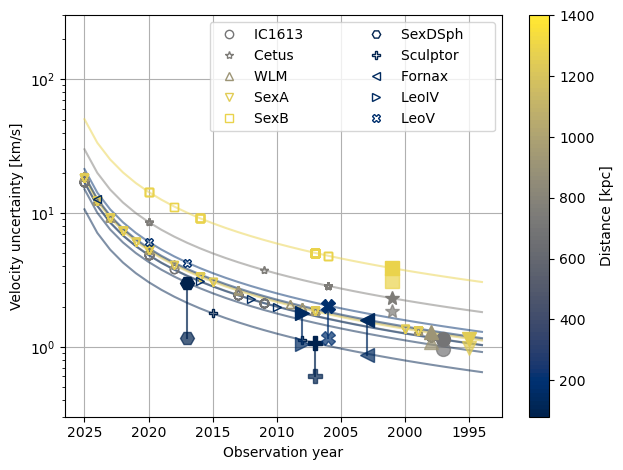

In [262]:
indices = [38,43,56,59,60]
obs = [ic1619,cetus,wlm,sexA,sexB]
markers = ['o','*','^','v','s']
for o,i,pm in zip(obs,indices,markers):
    #c=viridis(np.log10(nbgs[' D (Mpc)'][i]/dmax) - np.log10(dmin/dmax))
    c=viridis((nbgs[' D (Mpc)'][i]-dmin)/dmax)
    plt.semilogy(yr, 
                 velocity_limit_year(yr,nbgs[' D (Mpc)'][i]*u.Mpc,Nobs_hls=1+len(o['year'])),
                color=c,alpha=0.5)
    plt.semilogy(o['year'],
                 velocity_limit_year(o['year'].values*u.yr,nbgs[' D (Mpc)'][i]*u.Mpc,Nobs_hls=1+len(o['year'])),
                 marker=pm,ls='',mfc='none',mec=c,label=nbgs['Gal. Name    '][i],zorder=90)
    plt.semilogy(o['year'].min(),
                 velocity_limit_year(o['year'].min()*u.yr,nbgs[' D (Mpc)'][i]*u.Mpc,Nobs_hls=1+len(o['year'])),
                 marker=pm,ms=10,ls='',color=c,zorder=95)
    plt.semilogy(o['year'].min(),
                 velocity_limit_year(o['year'].min()*u.yr,nbgs[' D (Mpc)'][i]*u.Mpc,Nobs_hls=5+len(o['year']),hls_year=2032*u.yr),
                 marker=pm,ms=10,ls='',color=c,zorder=99,alpha=0.7)

for k in mw:
    #c=viridis(np.log10(nbgs[' D (Mpc)'][mwind[k]]/dmax) - np.log10(dmin/dmax))
    c=viridis((nbgs[' D (Mpc)'][mwind[k]]-dmin)/dmax)
    plt.semilogy(yr, 
                 velocity_limit_year(yr,nbgs[' D (Mpc)'][mwind[k]]*u.Mpc,Nobs_hls=1+len(mw[k])),
                 color=c,alpha=0.5)
    plt.semilogy(mw[k],
                 velocity_limit_year(mw[k]*u.yr,nbgs[' D (Mpc)'][mwind[k]]*u.Mpc,Nobs_hls=1+len(mw[k])),
                 marker=mwm[k],ls='',mfc='none',mec=c,label=nbgs['Gal. Name    '][mwind[k]],zorder=90)
    plt.semilogy(mw[k][0],
                 velocity_limit_year(mw[k][0]*u.yr,nbgs[' D (Mpc)'][mwind[k]]*u.Mpc,Nobs_hls=1+len(mw[k])),
                 marker=mwm[k],ms=10,ls='',color=c,zorder=95)
    plt.semilogy(mw[k][0],
                 velocity_limit_year(mw[k][0]*u.yr,nbgs[' D (Mpc)'][mwind[k]]*u.Mpc,Nobs_hls=5+len(mw[k]),hls_year=2032*u.yr),
                 marker=mwm[k],ms=10,ls='',color=c,zorder=99,alpha=0.7)
    plt.semilogy([mw[k][0],mw[k][0]],
                 [velocity_limit_year(mw[k][0]*u.yr,nbgs[' D (Mpc)'][mwind[k]]*u.Mpc,Nobs_hls=1+len(mw[k])).to(u.km/u.s).value,
                  velocity_limit_year(mw[k][0]*u.yr,nbgs[' D (Mpc)'][mwind[k]]*u.Mpc,Nobs_hls=5+len(mw[k]),hls_year=2032*u.yr).to(u.km/u.s).value],
                 ls='-',color=c,zorder=99,alpha=0.7)

plt.gca().invert_xaxis()
plt.xlabel('Observation year')
plt.ylabel('Velocity uncertainty [km/s]')
plt.ylim(0.3,300)
plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=dmin*1000, vmax=dmax*1000, clip=False),cmap=viridis),
    #mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=dmin*1000, vmax=dmax*1000, clip=False),cmap=viridis),
             ax=plt.gca(),
             orientation='vertical', label='Distance [kpc]')
plt.legend(ncol=2);
plt.grid();
plt.tight_layout();
plt.savefig('../figures/nbg_pms.png',dpi=300)

In [197]:
mpl.colors.LogNorm?

Init signature: mpl.colors.LogNorm(vmin=None, vmax=None, clip=False)
Docstring:      Normalize a given value to the 0-1 range on a log scale.
File:           /opt/anaconda3/envs/py312/lib/python3.12/site-packages/matplotlib/colors.py
Type:           type
Subclasses:     

In [80]:
nbgs.keys()

Index(['Gal. Name    ', 'RA J2000  ', 'DEC J2000', 'Bmag ', ' Kmag ',
       'Maj. Diam (kpc)', ' D (Mpc)', '  HRV (km/s)   ', 'AbsBmag ',
       ' angle  ', 'Maj_arcmin', 'Unnamed: 12'],
      dtype='object')

In [122]:
nbgs['Gal. Name    '][nbgs_in_hlwas_north]

14     SexDSph      
20     LeoIV        
21     LeoV         
59     SexA         
60     SexB         
188    NGC4700      
215    DDO153       
228    MCG-02-33-075
235    DDO148       
245    NGC4594      
247    NGC3115      
249    NGC4517      
250    UGCA193      
Name: Gal. Name    , dtype: object